In [31]:
import numpy as np
import  matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [3]:
%matplotlib inline

In [139]:
class GARCH11:
    
    def __init__(self):
        self.S0 = 100
        self.r = 0.05
        self.T = 0.5
        self.K = [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
        
        self.long_run_vol_squared = 0.3 * 0.3
        self.stochastic_vol_squared = 0.35 * 0.35
        
        self.alpha = 0.080
        self.beta = 0.885
        self.gamma = 0.035
        self.steps = 252
        self.dt = self.T/self.steps
        self.square_root_dt = np.sqrt(self.dt)
    
    def generate_path(self, sim):
        st = np.zeros((sim, self.steps))
        st[:, 0] = self.S0
        stochastic_vol_squared = np.zeros((sim, self.steps))
        stochastic_vol_squared[:, 0] = self.stochastic_vol_squared
        B = np.zeros((sim, self.steps))
        std_normal = np.random.standard_normal((sim, self.steps))
        
        for i in range(1, self.steps):
            mu = (self.r - 0.5 * stochastic_vol_squared[:, i-1]) * self.dt
            B[:, i] = self.square_root_dt * np.sqrt(stochastic_vol_squared[:, i-1])*std_normal[:, i-1]
            st[:, i] = st[:, i-1] * np.exp(mu + B[:, i])
            stochastic_vol_squared[:, i] = self.gamma * self.long_run_vol_squared + self.beta * stochastic_vol_squared[:, i-1] + self.alpha * B[:, i] * B[:, i] / self.dt
        
        return st, stochastic_vol_squared
    
    def price_option(self, price_path, K):
        '''
        This function returns an array of call option prices
        depending on different strikes
        '''
        
        payoff_sum = np.sum(np.exp(-self.r * self.T) * np.maximum(price_path[:,self.steps - 1] - K, 0.0))

        return payoff_sum / len(price_path[:,self.steps-1])
    
    def black_scholes(self, T, S0, K, sigma, r):
        '''
        Returns option price using Black-Scholes Formula
        '''
        '''
        S0 = float(S0)
        d1 = (np.log(S0/K) + (r + 0.5 * (sigma * sigma))* T) / (sigma * np.sqrt(T))
        d2 = (np.log(S0/K) + (r - 0.5 * (sigma * sigma))* T) / (sigma * np.sqrt(T))

        return S0 * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0)
        '''
        
        v = sigma * np.sqrt(T)
        
        if v < 0.0000001:
            S0 *= np.exp(r*T)
            val = S0 - K if S0 > K else 0
            val *= np.exp(-r*T)
        else:
            d0 = (np.log(S0/K) + r*T)/v
            d_plus = d0 + 0.5 * v
            d_minus = d0 - 0.5 * v
            
            val = S0 * norm.cdf(d_plus) - K*np.exp(-r*T)*norm.cdf(d_minus)
            
        return val if val > 0 else 0
    

    def implied_vol(self, S0, K, T, r, call_price):
        
        step = 0.1
        sigma = 0.0
        
        init_val = self.black_scholes(T, S0, K, 0.0, r)
        
        if init_val > call_price:
            return -1
        
        if call_price < init_val + 0.0000001:
            return 0.0
        
        val = init_val
        j = 1
        while j <= 5:
            while val <= call_price:
                sigma += step
                val = self.black_scholes(T, S0, K, sigma, r)
            sigma -= step
            val = self.black_scholes(T, S0, K, sigma, r)
            step /= 10
            j += 1
        return sigma
    

In [140]:
test1 = GARCH11()

In [141]:
# test with 1000 simulations
stock_price_path, stochastic_vol_squared = test1.generate_path(1000)

In [142]:
call_prices = {}
for x in test1.K:
    call_prices[x] = test1.price_option(stock_price_path, x)

In [143]:
call_prices

{50: 51.895559742732864,
 60: 42.167523259895056,
 70: 32.71392431124125,
 80: 23.831544880324575,
 90: 16.11272492599371,
 100: 10.097048604589972,
 110: 5.8843435539302078,
 120: 3.1429105824662509,
 130: 1.6198064769314811,
 140: 0.75228231444476323,
 150: 0.32041927826314026}

In [144]:
mock_prices = {50 : 51.2443,  60 : 41.5486, 70: 32.0748,80:  23.2467, 90: 15.6789, 100:  9.8459, 110:  5.8126, 120:  3.2759, 130:  1.7939, 140:  0.9702, 150:  0.5253}

In [145]:
implied_vols = {}
for x in test1.K:
    implied_vols[x] = test1.implied_vol(test1.S0, x, test1.T, test1.r, call_prices[x])
    print(implied_vols[x])

0.62442
0.95052
0.69116
0.49043
0.36254
0.31679


KeyboardInterrupt: 

In [146]:
test1.K

[50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]

In [147]:
implied_vols = [0.35183, 0.33093, 0.31912, 0.31227, 0.30882, 0.30767, 0.30819, 0.30996, 0.31276, 0.31633, 0.32050]

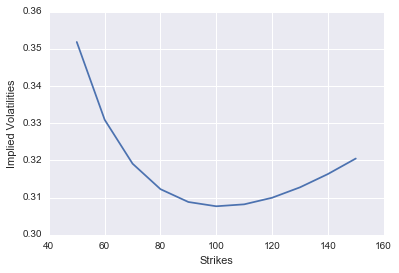

In [152]:
plt.plot(test1.K, implied_vols)
plt.xlabel('Strikes')
plt.ylabel('Implied Volatilities')
plt.legend()
plt.show()